In [2]:
import odc.geo.xr
import xarray as xr
import geopandas as gpd
import rasterio.features
from shapely.geometry import shape

ModuleNotFoundError: No module named 'odc'

In [16]:
da = xr.open_dataset('../data/ipcc_climate_zones.nc')['ipcc_climate_zone']
crs = 'EPSG:4326'
da = da.odc.assign_crs(crs)

In [19]:
def xr_vectorize(
    da,
    attribute_col=None,
    crs=None,
    dtype="float32",
    output_path=None,
    verbose=True,
    **rasterio_kwargs,
):
    """
    Vectorises a raster ``xarray.DataArray`` into a vector
    ``geopandas.GeoDataFrame``.

    Parameters
    ----------
    da : xarray.DataArray
        The input ``xarray.DataArray`` data to vectorise.
    attribute_col : str, optional
        Name of the attribute column in the resulting
        ``geopandas.GeoDataFrame``. Values from ``da`` converted
        to polygons will be assigned to this column. If None,
        the column name will default to 'attribute'.
    crs : str or CRS object, optional
        If ``da``'s coordinate reference system (CRS) cannot be
        determined, provide a CRS using this parameter.
        (e.g. 'EPSG:3577').
    dtype : str, optional
         Data type  of  must be one of int16, int32, uint8, uint16,
         or float32
    output_path : string, optional
        Provide an optional string file path to export the vectorised
        data to file. Supports any vector file formats supported by
        ``geopandas.GeoDataFrame.to_file()``.
    verbose : bool, optional
        Print debugging messages. Default True.
    **rasterio_kwargs :
        A set of keyword arguments to ``rasterio.features.shapes``.
        Can include `mask` and `connectivity`.

    Returns
    -------
    gdf : geopandas.GeoDataFrame

    """

    # Run the vectorizing function
    vectors = rasterio.features.shapes(
        source=da.data.astype(dtype), transform=da.odc.transform, **rasterio_kwargs
    )

    # Convert the generator into a list
    vectors = list(vectors)

    # Extract the polygon coordinates and values from the list
    polygons = [polygon for polygon, value in vectors]
    values = [value for polygon, value in vectors]

    # Convert polygon coordinates into polygon shapes
    polygons = [shape(polygon) for polygon in polygons]

    # Create a geopandas dataframe populated with the polygon shapes
    attribute_name = attribute_col if attribute_col is not None else "attribute"
    gdf = gpd.GeoDataFrame(
        data={attribute_name: values}, geometry=polygons, crs=da.odc.crs
    )

    # If a file path is supplied, export to file
    if output_path is not None:
        if verbose:
            print(f"Exporting vector data to {output_path}")
        gdf.to_file(output_path)

    return gdf

In [57]:
gdf = xr_vectorize(da, attribute_col="climate_zone", crs=crs, dtype="int16")

In [58]:
final = gdf.dissolve(by='climate_zone').reset_index()

In [59]:
mapping = {
    0: 'no data',
    1: 'Tropical Montane',
    2: 'Tropical Wet',
    3: 'Tropical Moist',
    4: 'Tropical Dry',
    5: 'Warm Temperate Moist',
    6: 'Warm Temperate Dry',
    7: 'Cool Temperate Moist',
    8: 'Cool Temperate Dry',
    9: 'Boreal Moist',
    10: 'Boreal Dry',
    11: 'Polar Moist',
    12: 'Polar Dry',
}

In [60]:
final['climate_zone'] = final['climate_zone'].astype(int).map(mapping)

In [63]:
final

,climate_zone,geometry
0,no data,"MULTIPOLYGON (((-114.50000 28.50000, -114.5000..."
1,Tropical Montane,"MULTIPOLYGON (((-75.50000 -11.00000, -75.50000..."
2,Tropical Wet,"MULTIPOLYGON (((-144.00000 -28.00000, -144.500..."
3,Tropical Moist,"MULTIPOLYGON (((-177.50000 -29.50000, -178.000..."
4,Tropical Dry,"MULTIPOLYGON (((-70.50000 -18.50000, -71.00000..."
5,Warm Temperate Moist,"MULTIPOLYGON (((-177.00000 -43.50000, -176.000..."
6,Warm Temperate Dry,"MULTIPOLYGON (((-78.50000 -34.00000, -79.00000..."
7,Cool Temperate Moist,"MULTIPOLYGON (((-67.00000 -50.00000, -67.50000..."
8,Cool Temperate Dry,"MULTIPOLYGON (((-58.50000 -52.00000, -58.50000..."
9,Boreal Moist,"MULTIPOLYGON (((-118.50000 53.50000, -118.5000..."


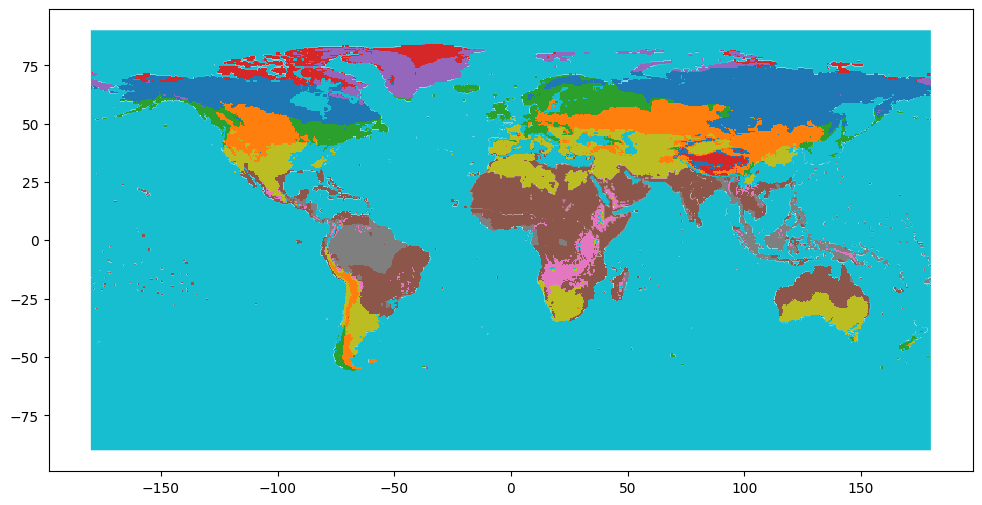

In [48]:
final.plot(column='climate_zone', figsize=(12,6));

In [65]:
final.to_file("../data/ipcc_climate_zones.geojson", driver='GeoJSON', index=True, crs=crs)